# Solution of the atom within LDA

First we take the code from the Hydrogen project and adopt it.

In [2]:
from scipy import *
from scipy import integrate
from scipy import interpolate
from scipy import optimize
from scipy import weave

def Numerovc(f, x0_, dx, dh_):
    code_Numerov="""
    double h2 = dh*dh;
    double h12 = h2/12.;
    
    double w0 = x(0)*(1-h12*f(0));
    double w1 = x(1)*(1-h12*f(1));
    double xi = x(1);
    double fi = f(1);
    for (int i=2; i<f.size(); i++){
        double w2 = 2*w1-w0+h2*fi*xi;  // here fi=f1
        fi = f(i);                     // fi=f2
        xi = w2/(1-h12*fi);
        x(i)=xi;
        w0 = w1;
        w1 = w2;
    }
    """
    x = zeros(len(f))
    dh=float(dh_)
    x[0]=x0_
    x[1]=x0_+dh*dx
    weave.inline(code_Numerov, ['f','dh','x'], type_converters=weave.converters.blitz, compiler = 'gcc')
    return x

def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

def ComputeSchrod(En,R,l):
    "Computes Schrod Eq." 
    f = fSchrod(En,l,R[::-1])
    ur = Numerovc(f,0.0,-1e-7,-R[1]+R[0])[::-1]
    norm = integrate.simps(ur**2,x=R)
    return ur*1/sqrt(abs(norm))

def Shoot(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    f0 = ur[0]
    f1 = ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0

def FindBoundStates(R,l,nmax,Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l))
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print 'Found bound state at E=%14.9f E_exact=%14.9f l=%d' % (Ebound, -1.0/(n+l)**2,l)
        u0=u1
    
    return Ebnd

def cmpE(x,y):
    if abs(x[1]-y[1])>1e-4:
        return cmp(x[1],y[1])
    else:
        return cmp(x[0],y[0])

# This is slightly modified code from Hydrogen project
def ChargeDensity(bst,R,Zatom):
    rho = zeros( len(R) )
    N=0
    for i,(l,Ei) in enumerate(bst):
        dN = 2*(2*l+1)
        if N+dN<Zatom:
            ferm=1
        else:
            ferm = (Zatom-N)/float(dN)
        u = ComputeSchrod(Ei,R,l)
        drho = u**2 / (4*pi*R**2) * dN * ferm
        rho += drho
        N += dN
        print 'Adding state with l=', l, 'and E=', Ei, 'with Z=', N, 'with ferm=', ferm
        if N>=Zatom: break
    return rho
    

Found bound state at E=  -0.999922109 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249990190 E_exact=  -0.250000000 l=0
Found bound state at E=  -0.111108201 E_exact=  -0.111111111 l=0
Found bound state at E=  -0.062498772 E_exact=  -0.062500000 l=0
Found bound state at E=  -0.039999314 E_exact=  -0.040000000 l=0
Found bound state at E=  -0.250000016 E_exact=  -0.250000000 l=1
Found bound state at E=  -0.111111117 E_exact=  -0.111111111 l=1
Found bound state at E=  -0.062500003 E_exact=  -0.062500000 l=1
Found bound state at E=  -0.039999959 E_exact=  -0.040000000 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=2
Found bound state at E=  -0.039999977 E_exact=  -0.040000000 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=3
Found bound state at E=  -0.039999992 E_exact=  -0.040000000 l=3
Adding state with l= 0 and E= -0.999922108956 with Z= 2 with ferm= 1
Adding state with l= 

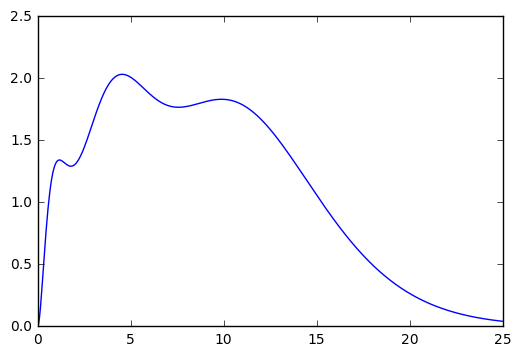

In [3]:
Esearch = -1.2/arange(1,20,0.2)**2

R = linspace(1e-8,100,2000)

nmax=5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
    
Bnd.sort(cmpE)

Zatom=28  # Like Ni ion
rho = ChargeDensity(Bnd,R,Zatom)

from pylab import *
%matplotlib inline

plot(R,rho*(4*pi*R**2),label='charge density')
xlim([0,25])
show()



In [4]:
def FuncForHartree(y,r,rhoSpline):
    return [y[1], -8*pi*r*rhoSpline(r)]

In [5]:
rhoSpline = interpolate.UnivariateSpline(R,rho,s=0)
U1 = integrate.odeint(FuncForHartree, [0.0,5.], R, args=(rhoSpline,))[:,0]
alpha = (2*Zatom-U1[-1])/R[-1]
U1 += alpha*R

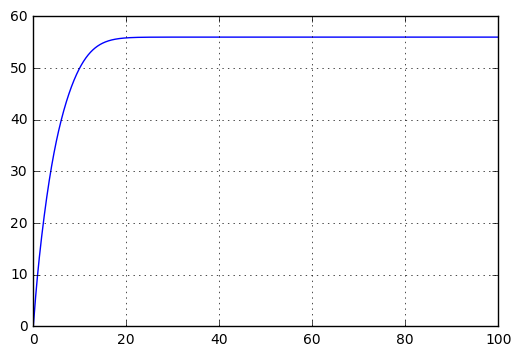

In [6]:
plot(R,U1)
grid()
show()

In [7]:
def NumerovU(U, x0, dx, dt):
    code_NumerovU="""
      double h2 = dt;
      h2 = h2*h2;
      double h12 = h2/12;
      
      double w0 = x(0)-h12*U(0);
      double w1 = x(1)-h12*U(1);
      double xi = x(1);
      double Ux = U(1);
      
      for (int i=2; i<U.size(); i++){
        double w2 = 2*w1 - w0 + h2*Ux;
        Ux = U(i);
        xi = w2+h12*Ux;
        x(i) = xi;
        w0 = w1;
        w1 = w2;
      }
    """
    x = zeros(len(U))
    x[0] = x0          # first point
    x[1] = dx*dt + x0  # second point
    
    weave.inline(code_NumerovU, ['U', 'x', 'dt'], type_converters=weave.converters.blitz, compiler = 'gcc')
    return x

In [8]:
ux = -8*pi*R*rho
U2 = NumerovU(ux, 0.0, 0.1, R[1]-R[0])
alpha2 = (2*Zatom-U2[-1])/R[-1]
U2 += alpha2*R


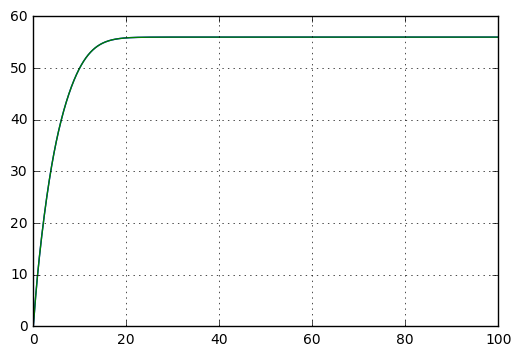

In [9]:
plot(R,U1)
plot(R,U2)
grid()
show()


Next we add exchange correlation potential. Make sure "excor.py" is in your working directory, so that we can import it.

In [10]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()
def rs(rho):
    "Given density, returns rs."
    if rho<1e-100: return 1e100
    return pow(3/(4*pi*rho),1/3.)

Vxc = [2*exc.Vx(rs(rh)) + 2*exc.Vc(rs(rh)) for rh in rho]

Uks = U2-2*Zatom + Vxc*R


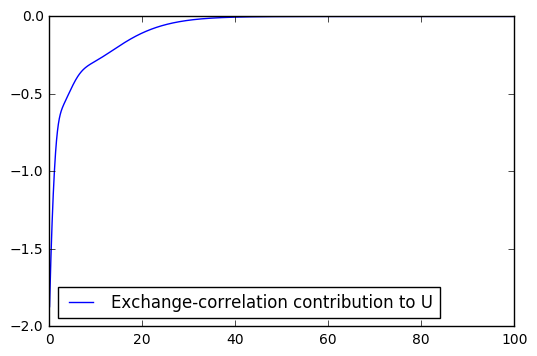

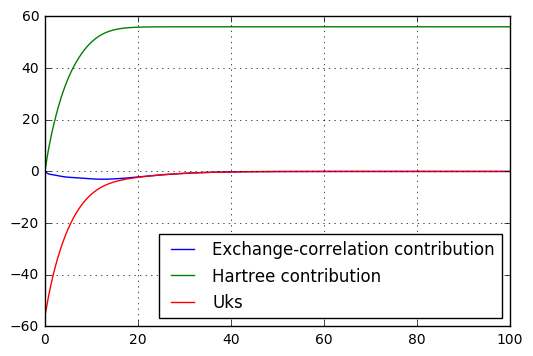

In [11]:
plot(R,Vxc, label='Exchange-correlation contribution to U')
legend(loc='best')
show()

plot(R,Vxc*R,label='Exchange-correlation contribution')
plot(R,U2,label='Hartree contribution')
plot(R,Uks, label='Uks')
legend(loc='best')
grid()
show()

Now it is time to reorganize the code and feed Hartree+Exchange correlation back to the Schroedinger equation.


In [12]:
from scipy import *
from scipy import integrate
from scipy import interpolate
from scipy import optimize
from scipy import weave

def Numerovc(f, x0_, dx, dh_):
    code_Numerov="""
    double h2 = dh*dh;
    double h12 = h2/12.;
    
    double w0 = x(0)*(1-h12*f(0));
    double w1 = x(1)*(1-h12*f(1));
    double xi = x(1);
    double fi = f(1);
    for (int i=2; i<f.size(); i++){
        double w2 = 2*w1-w0+h2*fi*xi;  // here fi=f1
        fi = f(i);                     // fi=f2
        xi = w2/(1-h12*fi);
        x(i)=xi;
        w0 = w1;
        w1 = w2;
    }
    """
    x = zeros(len(f))
    dh=float(dh_)
    x[0]=x0_
    x[1]=x0_+dh*dx
    weave.inline(code_Numerov, ['f','dh','x'], type_converters=weave.converters.blitz, compiler = 'gcc')
    return x

def NumerovU(U, x0, dx, dt):
    code_NumerovU="""
      double h2 = dt;
      h2 = h2*h2;
      double h12 = h2/12;
      
      double w0 = x(0)-h12*U(0);
      double w1 = x(1)-h12*U(1);
      double xi = x(1);
      double Ux = U(1);
      
      for (int i=2; i<U.size(); i++){
        double w2 = 2*w1 - w0 + h2*Ux;
        Ux = U(i);
        xi = w2+h12*Ux;
        x(i) = xi;
        w0 = w1;
        w1 = w2;
      }
    """
    x = zeros(len(U))
    x[0] = x0          # first point
    x[1] = dx*dt + x0  # second point
    
    weave.inline(code_NumerovU, ['U', 'x', 'dt'], type_converters=weave.converters.blitz, compiler = 'gcc')
    return x

def fSchrod2(En, R, l, Uks):
    return l*(l+1.)/R**2 + Uks/R - En
    #return l*(l+1.)/R**2-2./R-En

def ComputeSchrod(En,R,l,Uks):
    "Computes Schrod Eq." 
    f = fSchrod2(En,R[::-1],l,Uks[::-1])  # do not forget to turn around Uks!
    ur = Numerovc(f,0.0,-1e-7,-R[1]+R[0])[::-1]
    norm = integrate.simps(ur**2,x=R)
    return ur*1/sqrt(abs(norm))

def Shoot(En,R,l,Uks):
    ur = ComputeSchrod(En,R,l,Uks)
    #ur = ur/R**l
    f0 = ur[0]
    f1 = ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0

def FindBoundStates(R,l,nmax,Esearch,Uks):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        #print 'looking at energy', Esearch[i], u0,u1
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l,Uks))
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print 'Found bound state at E=%14.9f E_exact=%14.9f l=%d' % (Ebound, -1.0/(n+l)**2,l)
        u0=u1
    return Ebnd

def cmpE(x,y):
    if abs(x[1]-y[1])>1e-4:
        return cmp(x[1],y[1])
    else:
        return cmp(x[0],y[0])

# This is slightly modified code from Hydrogen project
def ChargeDensity(bst,R,Zatom,Uks):
    rho = zeros( len(R) )
    N=0
    for i,(l,Ei) in enumerate(bst):
        dN = 2*(2*l+1)
        if N+dN<Zatom:
            ferm=1
        else:
            ferm = (Zatom-N)/float(dN)
        u = ComputeSchrod(Ei,R,l,Uks)
        drho = u**2 / (4*pi*R**2) * dN * ferm
        rho += drho
        N += dN
        print 'Adding state with l=', l, 'and E=', Ei/2, ' Hartree with Z=', N, 'with ferm=', ferm
        if N>=Zatom: break
    return rho
    
    
def HartreeU(R, rho):
    ux = -8*pi*R*rho
    dudx=0.1
    U = NumerovU(ux, 0.0, dudx, R[1]-R[0])
    alpha2 = (2*Zatom-U[-1])/R[-1]
    U += alpha2*R
    return U

def rs(rho):
    "Given density, returns rs."
    if rho<1e-100: return 1e100
    return pow(3/(4*pi*rho),1/3.)


Found bound state at E=  -0.999998807 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999851 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -0.499999403471  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.124999925296  Hartree with Z= 4 with ferm= 1.0
Total density has weight= 4.0


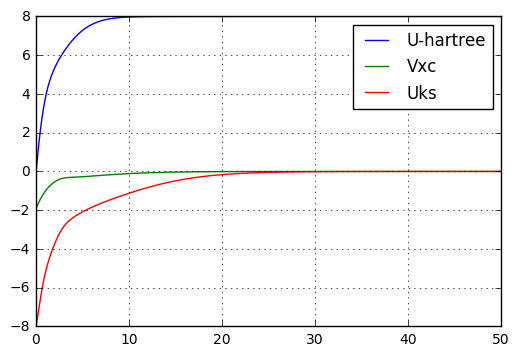

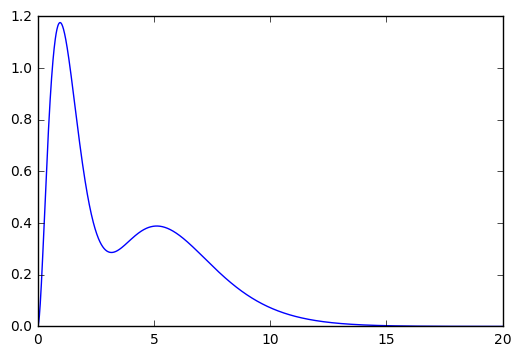

Found bound state at E= -12.847578370 E_exact=  -1.000000000 l=0
Found bound state at E=  -1.592504356 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -6.42378918503  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.796252177996  Hartree with Z= 4 with ferm= 1.0
Total density has weight= 4.0


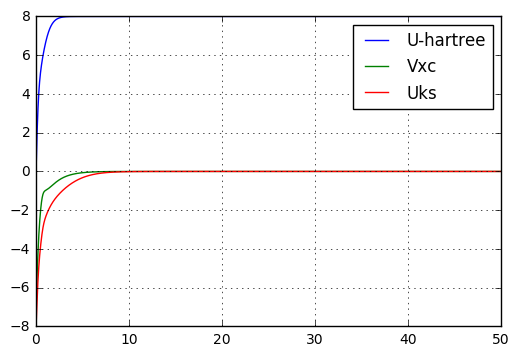

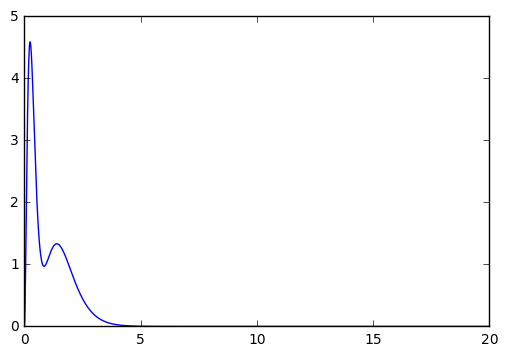

In [13]:

R = linspace(1e-8,50,2**12+1) # so that we can use Romberg method

nmax = 2
Zatom = 4

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift

exc = ExchangeCorrelation()
Uks = -2.*ones( len(R) )     # First iteration like hydrogen atom

for itt in range(2):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    Bnd.sort( cmpE )
    
    rho = ChargeDensity(Bnd,R,Zatom,Uks)
    
    U = HartreeU(R, rho)
    
    Vxc = [2*exc.Vx(rs(rh)) + 2*exc.Vc(rs(rh)) for rh in rho]
    
    Uks = U-2*Zatom + Vxc*R
    
    print 'Total density has weight=', integrate.simps(rho*(4*pi*R**2), x=R)
    
    plot(R,U, label='U-hartree')
    plot(R,Vxc,label='Vxc')
    plot(R, Uks, label='Uks')
    legend(loc='best')
    grid()
    show()
    plot(R, rho*(4*pi*R**2))
    xlim([0,20])
    show()

Next we will include charge density mixing, which will improve convergence. We will take a fraction of the new, and a fraction of the old charge density at each iteration.


Found bound state at E=  -0.999998807 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999851 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -0.499999403471  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.124999925296  Hartree with Z= 4 with ferm= 1.0
Total density has weight= 4.0
Found bound state at E= -12.847578370 E_exact=  -1.000000000 l=0
Found bound state at E=  -1.592504356 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -6.42378918503  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.796252177996  Hartree with Z= 4 with ferm= 1.0
Total density has weight= 4.0
Found bound state at E=  -9.809331493 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.759401416 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -4.90466574638  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.379700708221  Hartree with Z= 4 with ferm= 1.0
Total density has weight= 4.0
Found bound state at E=  -6.716105845 E_exact=  

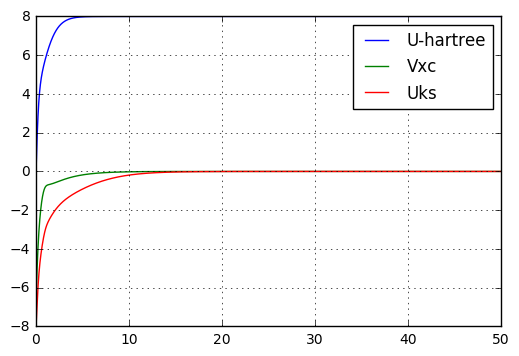

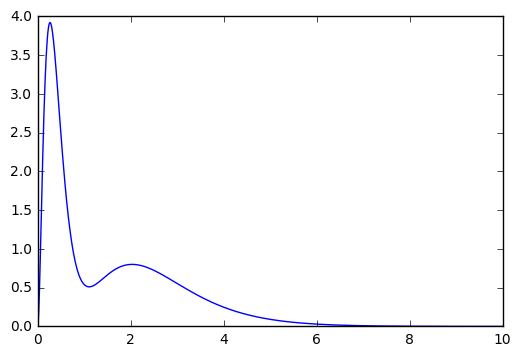

In [54]:
R = linspace(1e-8,50,2**12+1) # so that we can use Romberg method

nmax = 2
Zatom = 4
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift

exc = ExchangeCorrelation()
Uks = -2.*ones( len(R) )     # First iteration like hydrogen atom

for itt in range(30):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    Bnd.sort( cmpE )
    
    rho_new = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt>0:
        rho = rho_new*mixr + (1-mixr)*rho_old
    else:
        rho = rho_new
    rho_old = copy(rho_new)
    
    U = HartreeU(R, rho)
    
    Vxc = [2*exc.Vx(rs(rh)) + 2*exc.Vc(rs(rh)) for rh in rho]
    
    Uks = U-2*Zatom + Vxc*R
    
    print 'Total density has weight=', integrate.simps(rho*(4*pi*R**2), x=R)
  

plot(R,U, label='U-hartree')
plot(R,Vxc,label='Vxc')
plot(R, Uks, label='Uks')
legend(loc='best')
grid()
show()
plot(R, rho*(4*pi*R**2))
xlim([0,10])
show()

Finally we add the total energy. At each iteration, we will evaluate 

\begin{eqnarray}
E^{LDA}_{total} &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2]\psi_i(\vec{r}) +\nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [V_{nucleous}(\vec{r})+\epsilon_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\int d\vec{r}
\psi_i^*(\vec{r})[-\nabla^2+V_{nucleous}+V_H+V_{XC}]\psi_i(\vec{r})
 \nonumber\\
 &+& \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [\epsilon_H(\vec{r})-V_H(\vec{r}) +
   \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\nonumber\\
 &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r}) [-\epsilon_H(\vec{r}) + \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]\\
  &=& \sum_{i\in occupied}\epsilon_i + \int d\vec{r} \rho(\vec{r})[
  -\frac{1}{2} V_H(\vec{r}) + \epsilon_{XC}(\vec{r})-V_{XC}(\vec{r})]
\end{eqnarray}

Here we used

\begin{eqnarray}
&& E_y[\rho] \equiv \int d\vec{r}\; \rho(\vec{r})\; \epsilon_y[\rho(\vec{r})]\\
&& V_y[\rho]\equiv \frac{\delta E_y[\rho]}{\delta \rho(\vec{r})}
\end{eqnarray}
where $y$ is one of $H$, $x$ or $c$. 


Found bound state at E=  -0.999999849 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999981 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -0.499999924717  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.124999990581  Hartree with Z= 4 with ferm= 1.0
Itteration 0 Etot[Ry]= -6.75545868729 Etot[Hartre]= -3.37772934365 Diff= 6.75545868729
Total density has weight= 4.0
Found bound state at E= -12.848578363 E_exact=  -1.000000000 l=0
Found bound state at E=  -1.592599732 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -6.42428918151  Hartree with Z= 2 with ferm= 1
Adding state with l= 0 and E= -0.796299866236  Hartree with Z= 4 with ferm= 1.0
Itteration 1 Etot[Ry]= -37.3774530953 Etot[Hartre]= -18.6887265477 Diff= 30.6219944081
Total density has weight= 4.0
Found bound state at E=  -9.810074652 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.759434866 E_exact=  -0.250000000 l=0
Adding state with l= 0 and E= -4.90503732579  Hartree with Z=

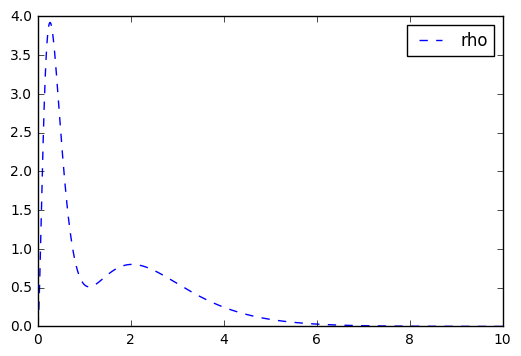

In [14]:
def ChargeDensity(bst,R,Zatom,Uks):
    rho = zeros( len(R) )
    N=0
    Ebs=0.
    for i,(l,Ei) in enumerate(bst):
        dN = 2*(2*l+1)
        if N+dN<Zatom:
            ferm=1
        else:
            ferm = (Zatom-N)/float(dN)
        u = ComputeSchrod(Ei,R,l,Uks)
        drho = u**2 / (4*pi*R**2) * dN * ferm
        rho += drho
        N += dN
        Ebs += Ei*dN*ferm
        print 'Adding state with l=', l, 'and E=', Ei/2, ' Hartree with Z=', N, 'with ferm=', ferm
        if N>=Zatom: break
    return (rho,Ebs)





R = linspace(1e-8,50,2**13+1) # so that we can use Romberg method
Etol=1e-7
nmax = 2
Zatom = 4
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -logspace(-4,log10(-E0+Eshift),200)[::-1] + Eshift

exc = ExchangeCorrelation()
Uks = -2.*ones( len(R) )     # First iteration like hydrogen atom
Eold=0

for itt in range(30):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    Bnd.sort( cmpE )
    
    (rho_new,Ebs) = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt>0:
        rho = rho_new*mixr + (1-mixr)*rho_old
    else:
        rho = rho_new
    rho_old = copy(rho_new)
    
    U = HartreeU(R, rho)
    
    Vxc = [2*exc.Vx(rs(rh)) + 2*exc.Vc(rs(rh)) for rh in rho]
    
    Uks = U-2*Zatom + Vxc*R
    
    # Total energy
    ExcVxc = array([2*exc.EcVc(rs(rh))+2*exc.ExVx(rs(rh)) for rh in rho])
    pot=(ExcVxc*R**2-0.5*U*R)*rho*4*pi
    Etot = integrate.romb(pot, R[1]-R[0]) + Ebs
    print 'Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold)
    if itt>0 and abs(Etot-Eold)<Etol: break
    Eold = Etot
    
    print 'Total density has weight=', integrate.simps(rho*(4*pi*R**2), x=R)
  

plot(R, rho*(4*pi*R**2),'--', label='rho')
legend(loc='best')
xlim([0,10])
show()